# Getting started with EEG & Brain-Computer Interfaces

**Authors**:

 - Javi Rameerez javi@rameerez.com | [@rameerez [tw]](http://twitter.com/rameerez)

---

_This code is Open Source, released under a GPL License._

TODO: Intro to bootcamp course

Our first task will be to get our hands dirty doing some data wrangling. Let's take raw EEG data captured from our headset and import it in a way we can look at and work with. 

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

## Loading Bitbrain's .CSV EEG into a Pandas dataframe

Bitbrain's headset records EEG data in `.csv` files. These are easily loadaed into a Pandas dataframe.

First, we'll load a Bitbrain CSV

In [2]:
df = pd.read_csv("../data/2020-02-08-jv-baseline-activity-no-labels/EEG.csv")

Let's just check it's loaded correctly:

In [3]:
df.head()

,timestamp,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,EEG-ch7,EEG-ch8,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16
0,-507251281301,15287,-2,0,-7638.393358,3128.375692,-28749.724544,4414.245724,-20280.618189,-18446.496073,-11796.253542,-22106.904308,-13824.267907,-15562.240883,-14997.367725,-15640.905043,-31259.019989,-39953.216568,-24932.219175,-9674.779098
1,-507251281301,15287,-2,0,-7644.611051,3120.819552,-28757.292851,4409.512490,-20280.423506,-18450.791270,-11797.239125,-22110.615456,-13848.518127,-15564.893441,-15001.614251,-15635.526921,-31262.743304,-39964.775880,-24922.582359,-9678.526748
2,-507251281301,15287,-2,0,-7651.096433,3112.801040,-28761.296024,4402.674245,-20273.439248,-18454.770107,-11799.940354,-22113.998075,-13828.514433,-15566.158881,-14989.921095,-15632.509332,-31259.068660,-39941.864106,-24925.831134,-9679.926034
3,-507251281301,15287,-2,0,-7660.842758,3101.983957,-28769.703902,4394.047347,-20271.626261,-18454.928287,-11798.979106,-22116.078752,-13787.326779,-15565.684341,-14980.551968,-15632.606673,-31253.885221,-39911.286684,-24912.458835,-9675.265806
4,-507251281301,15287,-2,0,-7667.182128,3094.780681,-28774.510142,4386.174848,-20281.774120,-18457.726857,-11801.424813,-22119.327527,-13788.044673,-15568.811439,-14989.811586,-15643.837458,-31261.076330,-39919.001004,-24914.004133,-9678.222556


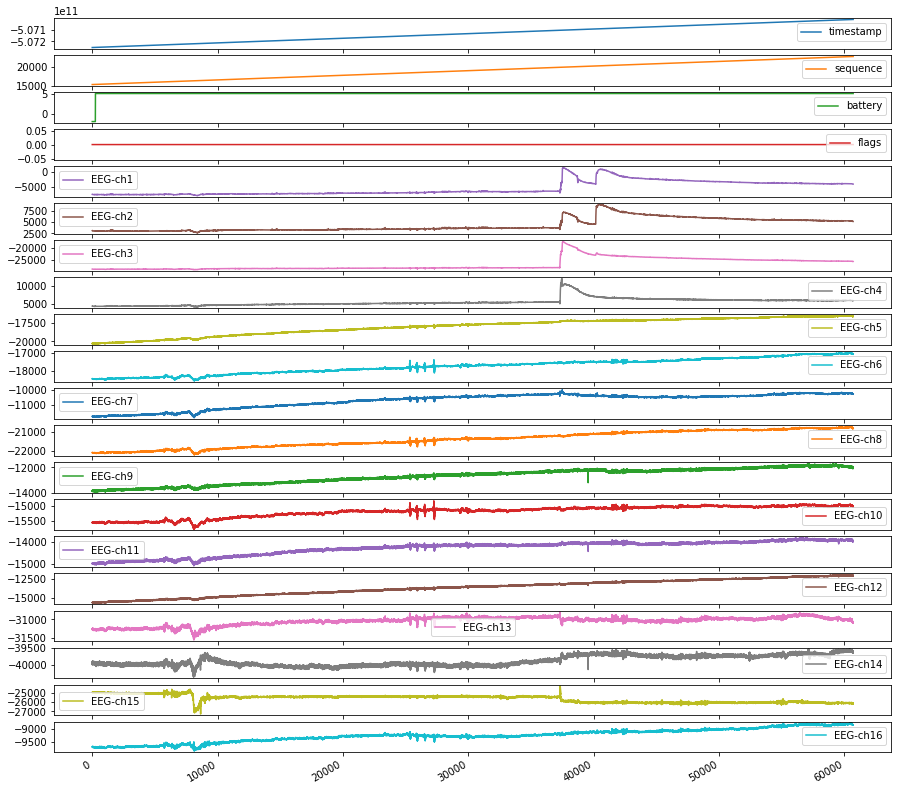

In [4]:
df.plot(subplots=True, figsize=(15, 15));

## From Pandas dataframe to MNE's `Raw` data structure

Okay, so we have our headset data in a Pandas dataframe, but how useful is that? The answer is: not much. We need to make use of a popular library in the BCI world, `mne`, which will come in very handy to work with EEG data.

First, we make sure we have it installed (`pip install mne`) and then we import it:

In [5]:
import mne

### Importing Bitbrain headset data into MNE
MNE uses a custom data structure, `Raw`, to hold EEG data.

`Raw` is composed of said EEG data plus certain `Info`, such as the number and name of the channels.

A handy class, `RawArray` is provided, which allows us to load `numpy` arrays into a MNE `Raw` structure.

In [6]:
df.columns

Index(['timestamp', 'sequence', 'battery', 'flags', 'EEG-ch1', 'EEG-ch2',
       'EEG-ch3', 'EEG-ch4', 'EEG-ch5', 'EEG-ch6', 'EEG-ch7', 'EEG-ch8',
       'EEG-ch9', 'EEG-ch10', 'EEG-ch11', 'EEG-ch12', 'EEG-ch13', 'EEG-ch14',
       'EEG-ch15', 'EEG-ch16'],
      dtype='object')

First, we remove non-EEG series from our data (like `timestamp` or `battery`).

In [7]:
df_mne = df.drop(['timestamp', 'sequence', 'battery', 'flags'], axis=1)

Then we convert the filtered dataframe into a Numpy array and transpose it (because MNE's `RawArray` takes a matrix where each row represents an EEG series, not a column like we had in our dataframe)

In [8]:
data_mne = df_mne.to_numpy().transpose()

If Bitbrain's data is not properly scaled, MNE plots are out of scale. We divide all measurements by 10^7

From https://github.com/mne-tools/mne-python/issues/5539

`You need to change the scaling of the plot or your data. Probably you have data in units of uV and MNE expects data in V`

In [9]:
data_mne = data_mne / 10000000

We then create the necessary `Info` object containing the name of each channel (which, as we later will see, has to be the name of the electrode position) and use it to create our `Raw` object

In [10]:
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C1', 'C3', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'CP4', 'Cz', 'O1', 'O2', 'Pz']

info_mne = mne.create_info(
    #ch_names=list(df_mne.columns),
    ch_names=channels,
    ch_types='eeg',
    sfreq=256)

bbt_raw = mne.io.RawArray(data_mne, info_mne)
print(bbt_raw)

Creating RawArray with float64 data, n_channels=16, n_times=60712
    Range : 0 ... 60711 =      0.000 ...   237.152 secs
Ready.
<RawArray  |  None, n_channels x n_times : 16 x 60712 (237.2 sec), ~7.4 MB, data loaded>


MNE comes with some predefined `Montage`s out of the box. A `Montage` represents the 3D position of each electrode within a skull.

One of the predefined montages is a pretty standard 10-20 montage, containing position info about 94 possible electrode positions. Since we've named our electrodes following their position within a 10-20 system, MNE will automatically take their position out of this predefined montage.

In [11]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
print(ten_twenty_montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>


In [12]:
raw_1020 = bbt_raw.copy().set_montage(ten_twenty_montage)

DigMontage is a superset of info. 78 in DigMontage will be ignored. The ignored channels are: {'O9', 'PO4', 'AF7', 'AF2', 'FT7', 'CPz', 'P2', 'AF6', 'T6', 'PO3', 'P9', 'F6', 'P4', 'T3', 'FT9', 'Iz', 'F2', 'FT8', 'P3', 'Fpz', 'P6', 'P8', 'M1', 'POz', 'T5', 'F5', 'P7', 'FC3', 'Oz', 'T10', 'O10', 'CP5', 'PO8', 'FC5', 'PO7', 'F10', 'AF4', 'M2', 'FC4', 'C5', 'C6', 'AFz', 'FC6', 'P1', 'A1', 'A2', 'FC1', 'AF8', 'F9', 'FT10', 'T7', 'PO10', 'AF10', 'TP9', 'AF3', 'T9', 'PO6', 'FC2', 'PO5', 'P5', 'T8', 'AF5', 'TP10', 'T4', 'F7', 'F8', 'F1', 'TP8', 'PO9', 'AF9', 'PO1', 'P10', 'PO2', 'FCz', 'AF1', 'TP7', 'Fz', 'CP6'}


The data is now imported and we can proceed to do anything we would do with an MNE raw object.

## Plotting our imported MNE data

Having our data in a way MNE can uderstand comes in very handy due to the vast amount of algorithms and functions that come with MNE, like plotting our data.

Let's just get familiar with the kind of plots that are available to us through MNE.

In [13]:
%matplotlib inline

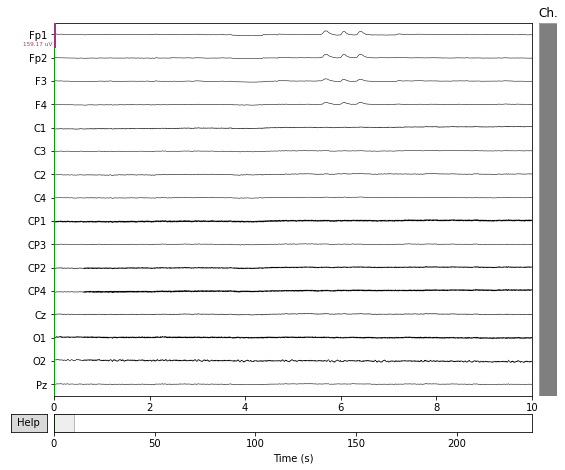

In [16]:
plot_fig = raw_1020.plot(scalings = 'auto')

Effective window size : 8.000 (s)


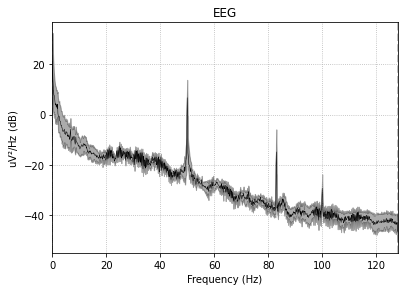

In [17]:
plot_psd_fig = raw_1020.plot_psd(average=True)

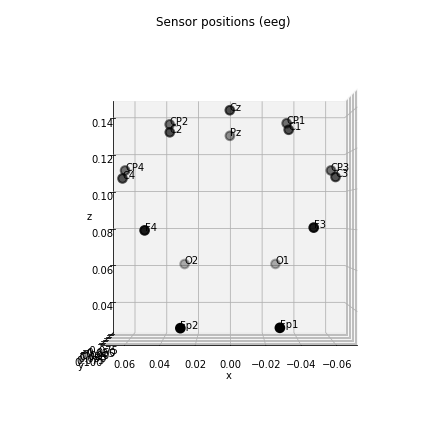

In [18]:
plot_sensors_fig = raw_1020.plot_sensors(kind='3d', show_names=True)

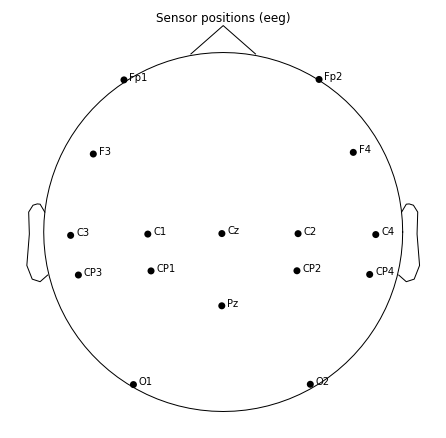

In [19]:
plot_sensors_topo_fig = raw_1020.plot_sensors(kind='topomap', show_names=True)